## 02_transfer_learning_vgg16_frozen_backbone.ipynb
This notebook continues from 01_data_loading_and_eda.ipynb  
- Same dataset loading logic (repeated for reproducibility)  
- Added data augmentation, normalization  
- Transfer learning with VGG16 (frozen backbone) → 88.1% val accuracy

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/car-damage-severity-dataset/data3a/training",
    labels="inferred",         
    label_mode="int",          
    batch_size=None,
    image_size=(256, 256),      
    shuffle=True,
)

class_names = train_ds.class_names
class_names

Found 1383 files belonging to 3 classes.


['01-minor', '02-moderate', '03-severe']

In [9]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/car-damage-severity-dataset/data3a/validation",
    labels="inferred",
    label_mode="int",
    batch_size=None,
    image_size=(256, 256),
    shuffle=False,
)


Found 248 files belonging to 3 classes.


## Splitting Data to Val and Train

In [11]:
val_size = int(len(train_ds) * 0.15)

val_ds = train_ds.take(val_size)
train_ds = train_ds.skip(val_size)

In [12]:
print(f"Size of the Train Dataset: {len(train_ds)}")
print(f"Size of the Validation Dataset: {len(val_ds)}")
print(f"Size of the Test Dataset: {len(test_ds)}")

Size of the Train Dataset: 1000
Size of the Validation Dataset: 176
Size of the Test Dataset: 248


## Build a best dataloader

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (train_ds
            .shuffle(1000)
            .batch(32)
            .prefetch(AUTOTUNE)
)

val_ds = (val_ds
            .batch(32)
            .prefetch(AUTOTUNE)
)

test_ds = (test_ds
            .batch(32)
            .prefetch(AUTOTUNE)
)

In [14]:
print(f"Length of the Train Batch: {len(train_ds)}")
print(f"Length of the Validation Batch: {len(val_ds)}")
print(f"Length of the test Batch: {len(test_ds)}")

Length of the Train Batch: 32
Length of the Validation Batch: 6
Length of the test Batch: 8


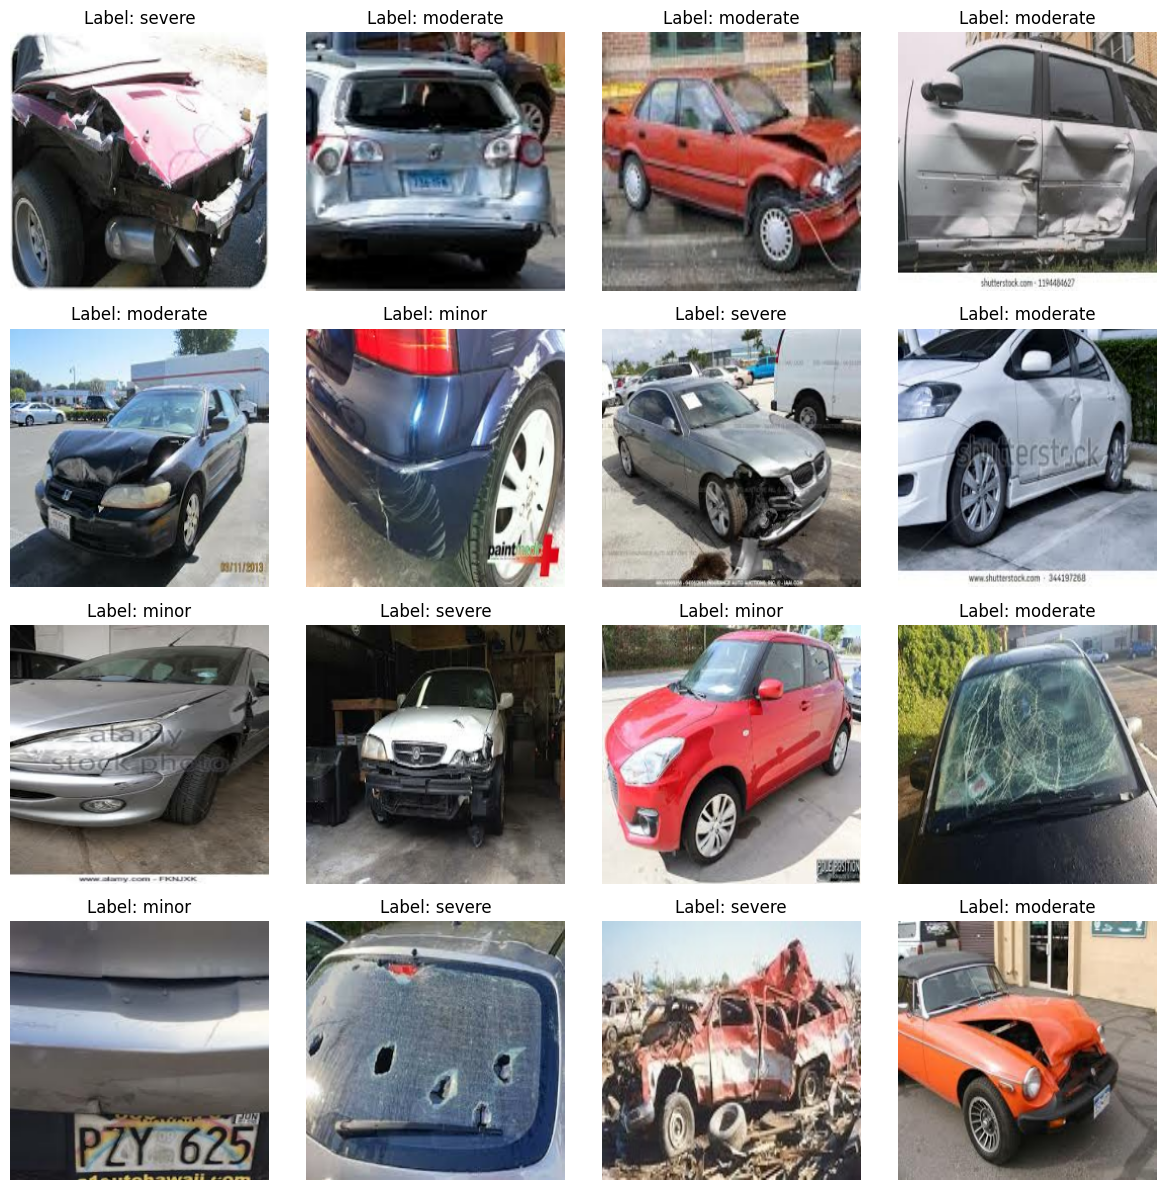

In [15]:
images, labels = next(iter(train_ds))

plt.figure(figsize=(12, 12))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    title = class_names[labels[i].numpy()]
    plt.title(f"Label: {title[3:]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Preprocessing

In [16]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds_n = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds_n = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds_n = test_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(train_ds_n))
first_image = image_batch[0]

print(f"min value of image: {np.min(first_image)} and max value of image: {np.max(first_image)}")


min value of image: 0.0003622616350185126 and max value of image: 1.0


## Data Augmentation

In [17]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

train_ds_n_ug = train_ds_n.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE
)

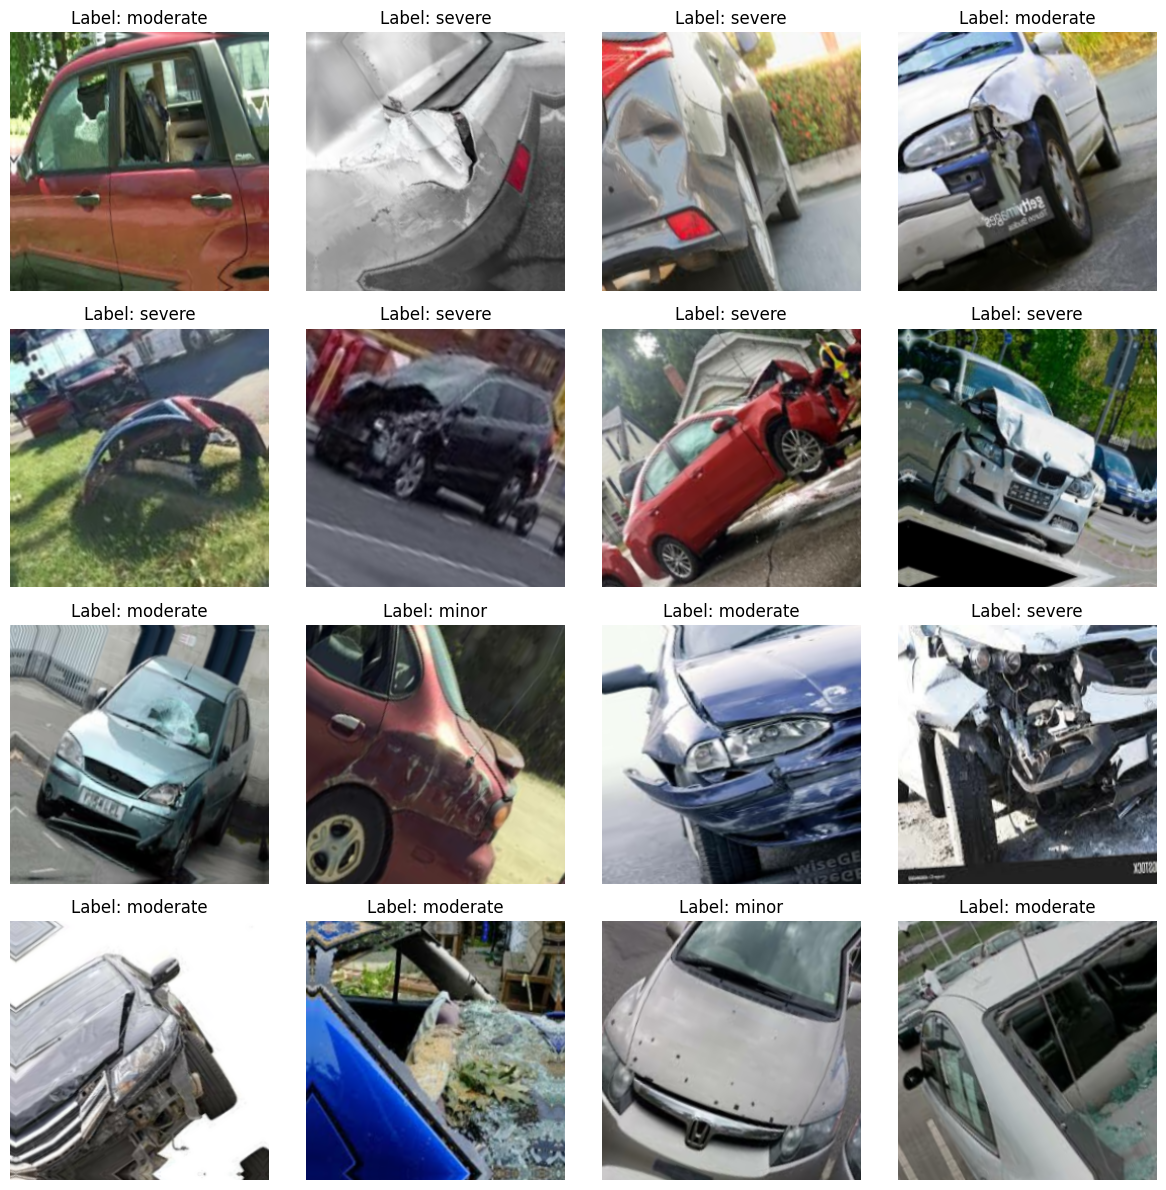

In [18]:
images, labels = next(iter(train_ds_n_ug))

plt.figure(figsize=(12, 12))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy())
    title = class_names[labels[i].numpy()]
    plt.title(f"Label: {title[3:]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## ResNet50

In [31]:
input_shape = (256, 256, 3)
num_classes = 3

base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)

base_model.trainable = False


inputs = layers.Input(shape=input_shape)

# Base
x = base_model(inputs, training=False)

# --- Strong Classification Head ---
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(512, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)

In [32]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [33]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=10,
                                         restore_best_weights=True)

In [34]:
history = model.fit(
    train_ds_n,
    validation_data=val_ds_n,
    epochs=50,
    callbacks = [early_stopping]
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 425ms/step - accuracy: 0.4063 - loss: 1.5439 - val_accuracy: 0.3750 - val_loss: 5.9669
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.4945 - loss: 0.9919 - val_accuracy: 0.3239 - val_loss: 7.7237
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.5295 - loss: 0.9526 - val_accuracy: 0.3352 - val_loss: 7.7393
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.5146 - loss: 0.9741 - val_accuracy: 0.4830 - val_loss: 1.1161
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.5412 - loss: 0.9697 - val_accuracy: 0.3750 - val_loss: 1.7900
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.5401 - loss: 0.9003 - val_accuracy: 0.4148 - val_loss: 1.2897
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.5141 - loss: 0.9538 - val_accuracy: 0.3352 - val_loss: 2.3428
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.5606 - loss: 0.8908 - val_accuracy: 0

Text(0.5, 0, 'Number of Epochs')

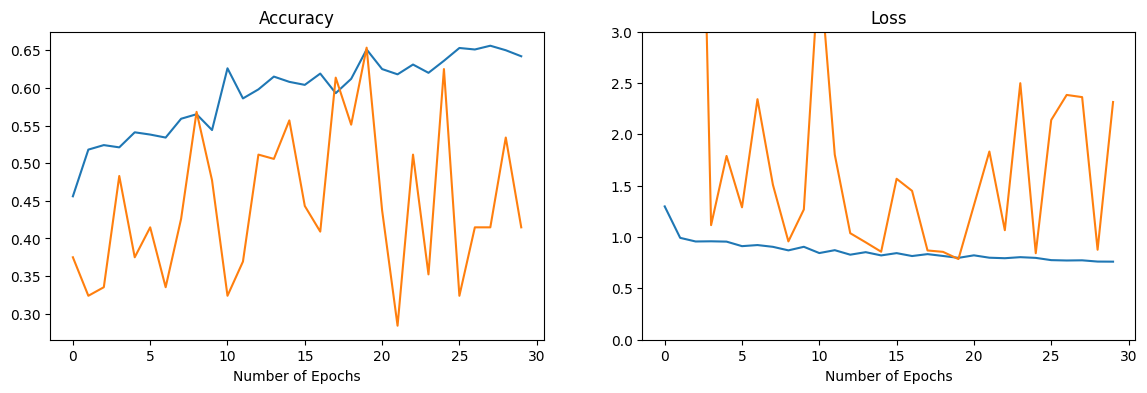

In [39]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epoch_size = len(history.history["val_accuracy"])

train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

fig , ax = plt.subplots(1,2, figsize=(14,4))
x = np.arange(epoch_size)
ax[0].plot(x, train_acc, label = "Train")
ax[0].plot(x, val_acc, label = "Validation")
ax[0].set_title("Accuracy")
ax[0].set_xlabel("Number of Epochs")

ax[1].plot(x, train_loss, label = "Train")
ax[1].plot(x, val_loss, label = "Validation")
ax[1].set_title("Loss")
ax[1].set_ylim([0,3])
ax[1].set_xlabel("Number of Epochs")

In [45]:
loss_test, acc_test = model.evaluate(test_ds_n)
print(f"the loss of the test Dataset:{loss_test.__round__(3)} and Accuracy: {acc_test.__round__(3)}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.6216 - loss: 0.9131
the loss of the test Dataset:0.896 and Accuracy: 0.613


## Custom Model

In [52]:
from tensorflow.keras import layers, models, optimizers

# Define the model
model_custom = models.Sequential()

# Convolutional and pooling layers
model_custom.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model_custom.add(layers.MaxPooling2D((2, 2)))

model_custom.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_custom.add(layers.MaxPooling2D((2, 2)))

model_custom.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_custom.add(layers.MaxPooling2D((2, 2)))


model_custom.add(layers.Flatten())


model_custom.add(layers.Dense(256, activation='relu'))
model_custom.add(layers.Dropout(0.3))

model_custom.add(layers.Dense(128, activation='relu'))
model_custom.add(layers.Dropout(0.3))


model_custom.add(layers.Dense(3, activation='softmax'))

# Compile the model
model_custom.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 50

history = model_custom.fit(
    train_ds_n,
    epochs=epochs,
    validation_data=val_ds_n,
    callbacks = [early_stopping]
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.3240 - loss: 1.1721 - val_accuracy: 0.3295 - val_loss: 1.0770
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.3744 - loss: 1.0856 - val_accuracy: 0.5455 - val_loss: 1.0235
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.5173 - loss: 1.0171 - val_accuracy: 0.5455 - val_loss: 0.9691
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.5416 - loss: 0.9532 - val_accuracy: 0.5000 - val_loss: 1.0158
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.4800 - loss: 1.0304 - val_accuracy: 0.5398 - val_loss: 0.9684
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.5669 - loss: 0.9145 - val_accuracy: 0.6477 - val_loss: 0.7988
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.5771 - loss: 0.8994 - val_accuracy: 0.7443 - val_loss: 0.7271
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.6624 - loss: 0.8084 - val_accuracy: 0.7102 -

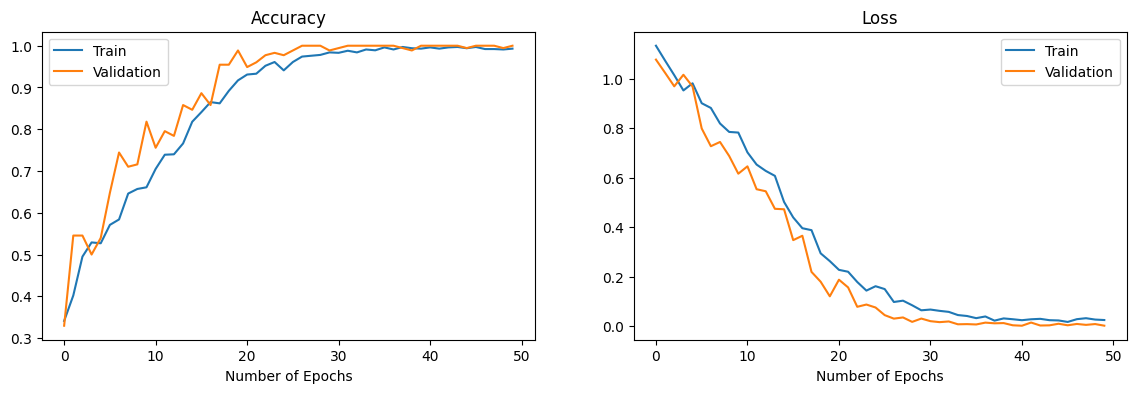

In [53]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epoch_size = len(history.history["val_accuracy"])

train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

fig , ax = plt.subplots(1,2, figsize=(14,4))
x = np.arange(epoch_size)
ax[0].plot(x, train_acc, label = "Train")
ax[0].plot(x, val_acc, label = "Validation")
ax[0].set_title("Accuracy")
ax[0].set_xlabel("Number of Epochs")
ax[0].legend()

ax[1].plot(x, train_loss, label = "Train")
ax[1].plot(x, val_loss, label = "Validation")
ax[1].set_title("Loss")
ax[1].set_xlabel("Number of Epochs")
ax[1].legend()

In [61]:
loss_test, acc_test = model_custom.evaluate(test_ds_n)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5390 - loss: 2.0614


## vgg16

In [65]:
input_shape = (256, 256, 3)
num_classes = 3

base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)

base_model.trainable = False


inputs = layers.Input(shape=input_shape)

# Base
x = base_model(inputs, training=False)

# --- Strong Classification Head ---
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(512, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

vgg16 = models.Model(inputs, outputs)


In [66]:
vgg16.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [67]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=10,
                                         restore_best_weights=True)

In [69]:
history = vgg16.fit(
    train_ds_n,
    validation_data=val_ds_n,
    epochs=50,
    callbacks = [early_stopping]
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 977ms/step - accuracy: 0.5478 - loss: 0.9771 - val_accuracy: 0.5398 - val_loss: 0.8960
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 293ms/step - accuracy: 0.6408 - loss: 0.8013 - val_accuracy: 0.5284 - val_loss: 0.9360
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 286ms/step - accuracy: 0.6339 - loss: 0.8311 - val_accuracy: 0.5284 - val_loss: 0.8998
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - accuracy: 0.6206 - loss: 0.7694 - val_accuracy: 0.6250 - val_loss: 0.7859
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step - accuracy: 0.6738 - loss: 0.7263 - val_accuracy: 0.6932 - val_loss: 0.6708
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 278ms/step - accuracy: 0.6861 - loss: 0.6846 - val_accuracy: 0.6989 - val_loss: 0.7677
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step - accuracy: 0.7210 - loss: 0.6562 - val_accuracy: 0.7102 - val_loss: 0.6564
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 283ms/step - accuracy: 0.6957 - loss: 0.6625 - val_accu

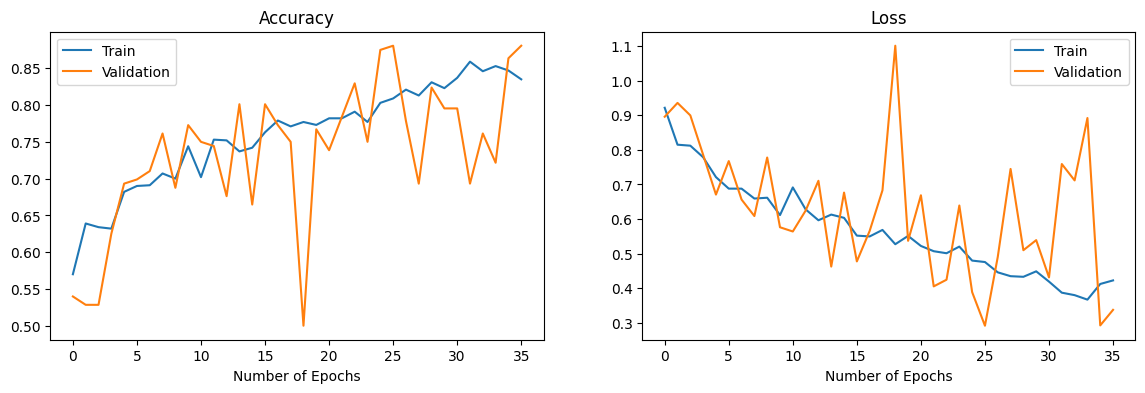

In [70]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epoch_size = len(history.history["val_accuracy"])

train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

fig , ax = plt.subplots(1,2, figsize=(14,4))
x = np.arange(epoch_size)
ax[0].plot(x, train_acc, label = "Train")
ax[0].plot(x, val_acc, label = "Validation")
ax[0].set_title("Accuracy")
ax[0].set_xlabel("Number of Epochs")
ax[0].legend()

ax[1].plot(x, train_loss, label = "Train")
ax[1].plot(x, val_loss, label = "Validation")
ax[1].set_title("Loss")
ax[1].set_xlabel("Number of Epochs")
ax[1].legend()

In [78]:
loss_vgg16, acc_vgg16 = vgg16.evaluate(test_ds_n)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.6058 - loss: 1.0524


In [79]:
print(f"Loss VGG16 : {loss_vgg16.__round__(2)}")
print(f"Accuracy VGG16 : {acc_vgg16.__round__(2)}")

Loss VGG16 : 0.91
Accuracy VGG16 : 0.65
